# CSCI 3202, Spring 2022: Final Coding Project

---


This is your final programming project for CSCI 3202. It is due on Canvas by **11:59 PM on Saturday April 30**.  Your solutions to theoretical questions should be done in Markdown/LateX directly below the associated question. Your solutions to computational questions should include any relevant Python code, as well as results and any written commentary.

You have two options for completing your final project for this course. The first option is presented in this notebook and involves implementing a reinforcement learning algorithm and producing a five-minute video that explains your process of solving this problem. The second option is to design your own project that includes the algorithms we've discussed since the midterm - Bayes Nets, Hidden Markov Models, Markov Decision Processes, or Reinforcement Learning - or an algorithm related to one of these that we haven't discussed in class. Your project also needs to include some kind of analysis of how it performed on a specific problem. If you're interested in the design your own project option, you need to discuss your idea with one of the course instructors to get approval. If you do a project without getting approval, you will receive a 0 regardless of the quality of the project. You will also need to produce a short, five-minute video that explains your project.

**The rules:**

1. Choose EITHER the given problem to submit OR choose your own project topic. 

2. If you choose your own project topic, please adhere to the following guidelines:
- The project needs to be approved by the course instructors.
- The project needs to include one of the algorithms we've discussed since the midterm - Bayes Nets, HMMs, MDPs, or Reinforcement Learning - or an algorithm that we haven't discussed in class. 
- If you do your own project without prior approval, you will receive a 0 for this project.
- Your project code, explanation, and results must all be contained in a Jupyter notebook. 

3. All work, code and analysis must be **your own**.
4. You may use your course notes, posted lecture slides, textbook, in-class notebooks and homework solutions as resources.  You may also search online for answers to general knowledge questions, like the form of a probability distribution function, or how to perform a particular operation in Python. You may not use entire segments of code as solutions to any part of this project, e.g. if you find a Python implementation of policy iteration online, you can't use it.
5. You may **not** post to message boards or other online resources asking for help.
6. **You may not collaborate with classmates or anyone else.**
7. This is meant to be like a coding portion of your final exam. So, we will be much less helpful than we typically am with homework. For example, we will not check answers, help debug your code, and so on.
8. If you have a question, post it first as a **private** Piazza message. If we decide that it is appropriate for the entire class, then we will make it a public post (and anonymous).
9. If something is left open-ended, it is probably because we intend for you to code it up however you want, and only care about the plots/analysis we see at the end. Feel free to ask clarifying questions though.

Violation of these rules will result in an **F** and a trip to the Honor Code council.

---
**By writing your name below, you agree to abide by these rules:**

**Your name:** Ryan Taylor

---



In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

# added packages
import heapq
from matplotlib import colors

import random



---
## [100 pts] Problem 1:  Reinforcement learning

Consider a **cube** state space defined by $0 \le x, y, z \le L$. Suppose you are piloting/programming a drone to learn how to land on a platform at the center of the $z=0$ surface (the bottom). Some assumptions:
* In this discrete world, if the drone is at $(x,y,z)$ it means that the box is centered at $(x,y,z)$. There are boxes (states) centered at $(x,y,z)$ for all $0 \le x,y,z \le L$. Each state is a 1 unit cube. So when $L=2$ (for example), there are cubes centered at each $x=0,1,2$, $y=0,1,2$ and so on, for a total state space size of $3^3 = 27$ states.
* All of the states with $z=0$ are terminal states.
* The state at the center of the bottom of the cubic state space is the landing pad. For example, when $L=4$, the landing pad is at $(x,y,z) = (2,2,0)$.
* All terminal states ***except*** the landing pad have a reward of -1. The landing pad has a reward of +1.
* All non-terminal states have a living reward of -0.01.
* The drone takes up exactly 1 cubic unit, and begins in a random non-terminal state.
* The available actions in non-terminal states include moving exactly 1 unit Up (+z), Down (-z), North (+y), South (-y), East (+x) or West (-x). In a terminal state, the training episode should end.

#### Part A
Write a class `MDPLanding` to represent the Markov decision process for this drone. Include methods for:
1. `actions(state)`, which should return a list of all actions available from the given state
2. `reward(state)`, which should return the reward for the given state
3. `result(state, action)`, which should return the resulting state of doing the given action in the given state

and attributes for:
1. `states`, a list of all the states in the state space, where each state is represented as an $(x,y,z)$ tuple
2. `terminal_states`, a dictionary where keys are the terminal state tuples and the values are the rewards associated with those terminal states
3. `default_reward`, a scalar for the reward associated with non-terminal states
4. `all_actions`, a list of all possible actions (Up, Down, North, South, East, West)
5. `discount`, the discount factor (use $\gamma = 0.999$ for this entire problem)

How you feed arguments/information into the class constructor is up to you.

Note that actions are *deterministic* here.  The drone does not need to learn transition probabilities for outcomes of particular actions. What the drone does need to learn, however, is where the landing pad is, and how to get there from any initial state.

Before moving on to Part B, we recommend that you test that your MDPLanding code is set up correctly. Write unit tests that display the actions for a given state, rewards, results, etc. This will help you identify errors in your implementation and save you a lot of debugging time later.

In [2]:
class MDPLanding:

    # constructor
    def __init__(self, size, default=-0.01, terminal=-1, goal=1):

        # set defaults if not given alternate rewards structures
        self.size = size
        self.default_reward = default
        self.terminal_reward = terminal
        self.goal_reward = goal

        # actual constant stuff
        self.all_actions = ['up', 'down', 'north', 'south', 'east', 'west']
        self.discount = 0.999

        # state space
        self.states = []
        for x in range(size+1):
            for y in range(size+1):
                for z in  range(size+1):
                    self.states.append((x,y,z))
        

        # setting terminal stataes, policies to be used in policy iteration
        self.terminal_states = {}
        self.policies = {}
        for state in self.states:
            default_policy = random.choice(self.actions(state))
            if state[2] == 0:
                if state[0] == state[1] and state[0] + state[1] == size:
                    self.policies[state] = self.goal_reward, state
                    self.terminal_states[state] = self.goal_reward
                else:
                    self.policies[state] = self.terminal_reward, state
                    self.terminal_states[state] = self.terminal_reward
            else:
                self.policies[state] = self.default_reward, default_policy


    # return all actions around given state
    def actions(self, state):
        output = []
        for s in self.states:
            if s[1] == state[1] and s[2] == state[2]:
                if s[0] == state[0] + 1 or s[0] == state[0] - 1:
                    output.append(s)
            if s[0] == state[0] and s[2] == state[2]:
                if s[1] == state[1] + 1 or s[1] == state[1] - 1:
                    output.append(s)
            if s[0] == state[0] and s[1] == state[1]:
                if s[2] == state[2] + 1 or s[2] == state[2] - 1:
                    output.append(s)
        return output


    # return reward of given state
    def reward(self, state):
        if state in self.terminal_states:
            return self.terminal_states[state]
        else:
            return self.default_reward


    # compute result of state given direction
    def result(self, state, action):

        # applying appropriate transformation to given state
        if action == 'up' or action == 0:
            new_state = (state[0], state[1], state[2] + 1)
        elif action == 'down' or action == 1:
            new_state = (state[0], state[1], state[2] - 1)
        elif action == 'north' or action == 2:
            new_state = (state[0], state[1] + 1, state[2])
        elif action == 'south' or action == 3:
            new_state = (state[0], state[1] - 1, state[2])
        elif action == 'east' or action == 4:
            new_state = (state[0] - 1, state[1], state[2])
        elif action == 'west' or action == 5:
            new_state = (state[0] + 1, state[1], state[2])

        # handle case of attempting impossible moves
        if new_state not in self.states:
            new_state = state

        # if random space, default reward and not reached end
        if state not in self.terminal_states:
            reward = self.default_reward
            is_done = False
        else:
            # if goal space, goal reward and reached end
            if self.reward(state) == self.goal_reward:
                reward = self.goal_reward
                is_done = True
            # terminal state, terminal reward and reached end
            else:
                reward = self.terminal_reward
                is_done = True

        return new_state, reward, is_done


    # for testing policy iteration
    # follow path of policies to terminal state
    def follow_path(self, start):
        path = [start]
        state = start
        while state not in self.terminal_states:
            new = self.policies[(state)]
            path.append(new[1])
            state = new[1]
        return path

#### Part B
Write a function to implement **policy iteration** for this drone landing MDP. Create an MDP environment to represent the $L=4$ case (so 125 total states).

Use your function to find an optimal policy for your new MDP environment. Check (by printing to screen) that the policy for the following states are what you expect, and **comment on the results**:
1. $(2,2,1)$
1. $(0,2,1)$
1. $(2,0,1)$

The policy for each of these states is the action that the agent should take in that state. 

In [3]:
# Bellman to compute utility of each spot
# u(state) = reward(state) + discount * max_reward(adjacent_moves)
def utility(MDP, state):

    possible_rewards = []
    possible_state = []
    for a in MDP.actions(state):
        possible_rewards.append(MDP.policies[a][0])
        possible_state.append(a)    
    max_reward = max(possible_rewards)
    # print(MDP.policies[state][0], max_reward)
    return  ((MDP.policies[state][0] + (MDP.discount * max_reward))), possible_state[possible_rewards.index(max_reward)]

# reset old policy dictionary
def reset(new):
    out = {}
    for a in new:
        out[a] = new[a][1]
    return out

# check if policies have not changed
def no_change(new, old):
    for a in new:
        if old[a] != new[a][1]:
            return False
    return True

# actually running the policy iteration
def policy_iteration(MDP):
    iters = 0
    old_policies = reset(MDP.policies)
    while True:
        # iterate over entire state space and update policies
        for state in MDP.states:
            MDP.policies[state] = utility(MDP, state)
        # break if no change
        if no_change(MDP.policies, old_policies) and iters>1:
            break
        # else loop
        else:
            old_policies = reset(MDP.policies)
        iters += 1
    print("Total policy iterations:", iters)


# create space and run policy iter within
test_state = MDPLanding(4)
policy_iteration(test_state)

# given test spaces
print("Next move from (2, 2, 1):", test_state.policies[(2, 2, 1)][1])
print("Next move from (0, 2, 1):", test_state.policies[(0, 2, 1)][1])
print("Next move from (2, 0, 1):", test_state.policies[(2, 0, 1)][1])
print()
print(test_state.follow_path((4, 4, 3)))

Total policy iterations: 6
Next move from (2, 2, 1): (2, 2, 0)
Next move from (0, 2, 1): (1, 2, 1)
Next move from (2, 0, 1): (2, 1, 1)

[(4, 4, 3), (3, 4, 3), (2, 4, 3), (2, 3, 3), (2, 2, 3), (2, 2, 2), (2, 2, 1), (2, 2, 0)]


For each of the given starting cases, the policy iteration gives the correct next move towards the landing pad. I also created a short path-following test just to see how different starting points play out, and most paths already end up at the landing pad. For certain x-values it does get confused, however this policy iteration is of course not a perfect algorithm.

---

#### Part C

Code up a **Q-learning** agent/algorithm to learn how to land the drone. You can do this however you like, as long as you use the MDP class structure defined above.  

Your code should include some kind of a wrapper to run many trials to train the agent and learn the Q values.  You also do not need to have a separate function for the actual "agent"; your code can just be a "for" loop within which you are refining your estimate of the Q values.

From each training trial, save the cumulative discounted reward (utility) over the course of that episode. That is, add up all of $\gamma^t R(s_t)$ where the drone is in state $s_t$ during time step $t$, for the entire sequence. We refer to this as "cumulative reward" because we usually refer to "utility" as the utility *under an optimal policy*.

Some guidelines:
* The drone should initialize in a random non-terminal state for each new training episode.
* The training episodes should be limited to 50 time steps, even if the drone has not yet landed. If the drone lands (in a terminal state), the training episode is over.
* You may use whatever learning rate $\alpha$ you decide is appropriate, and gives good results.
* There are many forms of Q-learning. You can use whatever you would like, subject to the reliability targets in Part D below.
* Your code should return:
  * The learned Q values associated with each state-action pair.
  * The cumulative reward for each training trial. 
  * Anything else that might be useful in the ensuing analysis.

In [4]:
# Temporal difference q learning alg
# = existing_q_value + learning_parameter((reward_at_state) + discount(max_change_in_q_value))

# Pseudocode from class for easy reference
# initialize
#   default policy, q, rewards
# for each run
#   random start state
#   for each step
#       if terminal
#           calculate cumulative reward
#           assign q value
#           exit
#       else
#           pick an action using e-greedy
#           count state-action pair
#           calculate q value using q learning eq
#           update policy
#           calculate cumulative reward using discount, step, reward
# return q, counter, cumulative rewards for trials 


# convert actions to integers
# for accessing list indices later on
def act_int(action):
    if action == 'up': return 0
    if action == 'down': return 1
    if action == 'north': return 2
    if action == 'south': return 3
    if action == 'east': return 4
    if action == 'west': return 5


# setting global parameters
# these could be set within the q_learning function but i found it easier to initialize them all at once
# this also makes it easier to change them later to run different tests
# around 20k episodes seemed to be best results without letting tests run for too long
N_EPISODES = 20000
MAX_EPISODE_STEPS = 50
MIN_EPSILON = 0.01
epsilons = np.linspace(0.8, MIN_EPSILON, N_EPISODES)
MIN_ALPHA = 0.6
alphas = np.linspace(0.6, MIN_ALPHA, N_EPISODES)


# I know our learning didn't have to be a function, again this just made it more repeatable with different spaces
def q_learn(space):

    # constant cumulative rewards and q values
    rewards = []
    Q = defaultdict(lambda: np.zeros(len(space.all_actions)))

    for e in range(N_EPISODES):
        
        # starting state, current epsilon/alpha values, reset cumulative reward
        state = random.choice(space.states)
        epsilon = epsilons[e]
        alpha = alphas[e]
        cumulative_reward = 0

        for _ in range(MAX_EPISODE_STEPS):
                
            # e-greedy choice of action to take
            if random.uniform(0, 1) < epsilon:
                move = act_int(random.choice(space.all_actions))
            else:
                move = np.argmax(Q[next_state]) 

            # get resulting state, reward, and whether on a terminal space
            next_state, reward, terminal = space.result(state, move)

            # update cumulative reward
            cumulative_reward += reward

            # calculate q value and update policy
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + space.discount * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][move]
            Q[state][move] += alpha * td_delta

            # break if terminal
            if terminal:
                break
                
            # move to next chosen state
            state = next_state

        # add rewardss to totals list
        rewards.append(cumulative_reward)

    return Q, rewards

#### Part D

Initialize the $L=10$ environment (so that the landing pad is at $(5,5,0)$). Run some number of training trials to train the drone.

**How do I know if my drone is learned enough?**  If you take the mean cumulative reward across the last 5000 training trials, it should be around 0.80. This means at least about 10,000 (but probably more) training episodes will be necessary. It will take a few seconds on your computer, so start small to test your code.

**Then:** Compute block means of cumulative reward from all of your training trials. Use blocks of 500 training trials. This means you need to create some kind of array-like structure such that its first element is the mean of the first 500 trials' cumulative rewards; its second element is the mean of the 501-1000th trials' cumulative rewards; and so on. Make a plot of the block mean rewards as the training progresses. It should increase from about -0.5 initially to somewhere around +0.8.

**And:** Print to the screen the mean of the last 5000 trials' cumulative rewards, to verify that it is indeed about 0.80.

In [10]:
# used this simple function i found to split up lists
# https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
# i had a much clunkier version but this is much simpler
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# easy repeatable plotting of a qiven q space
def plot_rewards(rewards):

    # splitting cumulative rewards list in chunks and taking averages
    rewards_blocks = list(chunks(rewards, 500))
    block_averages = []
    for block in range(len(rewards_blocks)):
        block_averages.append(np.mean(rewards_blocks[block]))

    # plot block averages
    plt.plot(list(range(0, N_EPISODES, 500)) ,block_averages)
    plt.xlabel("Iterations")
    plt.ylabel("Average Cumulative Reward")
    plt.show()

Mean of last 5000: 0.54874


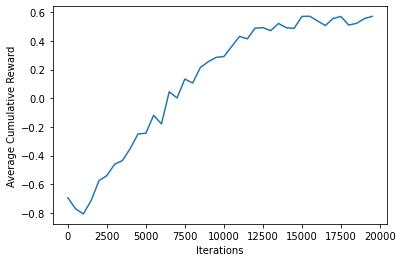

In [19]:
# seed for repeatability in testing
random.seed(122)

space = MDPLanding(10)

q_out, rewards = q_learn(space)
print("Mean of last 5000:", np.mean(rewards[-5000:]))
plot_rewards(rewards)

I understand that my attained 0.55 is as high as the 0.8 average reward we were expected to reach. As far as I'm able to discern, my agent/algorithm and the math performed within match the pseudo code and algorithms we were given. I did also try playing the epsilon and alpha values, however doing this I was not able to get my average reward any higher than this 0.55.

---

#### Part E

**Question 1:** Why does the cumulative reward start off around -0.5 at the beginning of the training?  
During the first iterations of our training, the agent is mostly just randomly moving about the space until either time is up or it finds a terminal state. Most of the time at this stage, the drone will just move randomly until the maximum time is reached. Given our maximum time steps is 50, terminal state reward is -1, and goal reward is 1, the goal and terminal rewards would average out leaving us with the -0.50 from the $50*-0.01$ from our default space rewards.

**Question 2:** Why will it be difficult for us to train the drone to reliably obtain rewards much greater than about 0.8?  
Given a $10*10*10$ state space, even in runs where the drone effectively navigates to the goal, there will still be a non-zero numbers of steps taken to get there. With our goal reward being 1 by default, each step taken towards the goal hurts our final cumulative reward fairly substantially. Of course we must also consider that there are still occurences of reaching a terminal non-goal state even late in our trainging, which would also sharply decrease that average.

#### Part F
Choose three other reward structures, including the terminal rewards and the living rewards, and rerun your policy iteration and Q-learning algorithms with those reward structures. Write a paragraph or two describing the reward structures that you selected, what impact you expected the changes to have on your results, and what changes actually happened. If there was a difference in what you expected and what actually happened, reflect on why there was a difference. 

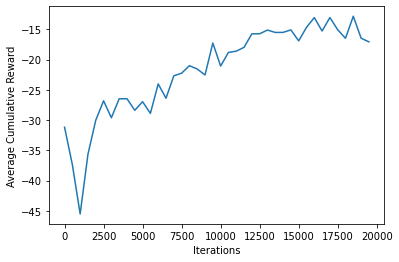

In [16]:
space = MDPLanding(10, terminal=-100)
q_out, rewards = q_learn(space)
plot_rewards(rewards)

My first new structure was to give the terminal spaces a much much worse reward, while leaving the default and goal rewards the same. I honestly did not really know what to expect here, as the drone would most likely more quickly learn that terminal spaces are bad, however when it did land on one the impact to the cumulative reward would be substantial. After running the test for certain, we can definitely observe that jumpiness in the graph. We observe a much more mellow slope, as the drone learns the terminal spaces are bad very quickly and avoids them, however the inconsistencies result from such a large negative reward upon accidentally landing on one of those -100 spaces.

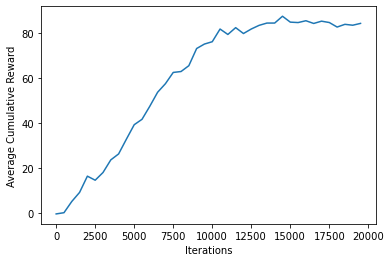

In [14]:
space = MDPLanding(10, goal=100)
q_out, rewards = q_learn(space)
plot_rewards(rewards)

For this structure, I gave the goal 100x it's normal reward value while leaving the other defaults alone. I expected structure to result in similar results in the beginning, but as soon as the drone began to find the goal more and more I expected to see a sharp jump in the cumulative rewards. In the beginning when the drone is mostly just randomly moving about the space, a large goal increase would not change that, however the huge boost in reward once the drone found it, I that thought would be significant. Looking at the actual graph however, the reward does appear to peak maybe *slightly* earlier, but nothing terribly significant. I'm not completely sure as to why this is, my best guess might be that becuase the goal is given so much weight, the drone may be just missing by one or two spaces and landing more often on an adjacent space.

No care to default spaces


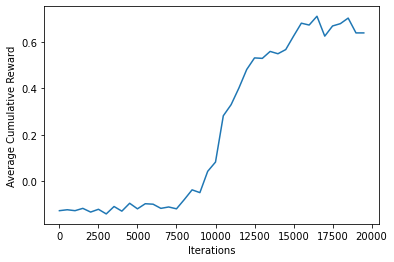

In [18]:
print("No care to default spaces")
space = MDPLanding(10, default=0)
q_out, rewards = q_learn(space)
plot_rewards(rewards)

This last structure consisted of giving no negative reward at all for default non-terminal spaces. I expected this one to take a while to learn anything, as the drone has no consequences for just flying around and not finding anything. With the other structures, the slight penalty for each step taken quickly teaches the drone to find the goal space as quickly as possible. Without that reinforcement here, I expected a lower slop or just not much to occur during the first iterations, and the graph proves this. We actually observe no real change for much longer than I expected, almost half of the episodes. However, once the drone starts more frequently making it to the terminal states it learns very quickly.